In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
#print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

## Load selected units in area of interest

In [6]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


## Check optotag

In [7]:
bin_width = 0.0005 # 0.5 ms bins
window = (-0.010, 0.020)

baseline_window = (-0.010, -0.001)
evoked_window = (0.001, 0.010)

# get trials with duration 10 ms
opto_epochs = session.optogenetic_stimulation_epochs
trials = opto_epochs[(opto_epochs.duration > 0.009) & (opto_epochs.duration < 0.02)]

In [8]:
def optotagging_spike_counts(session, trials, unit_ids, bin_width=0.03, window=(-1.0, 1.0)):
    """Count spikes in bins for each optotagging trial"""
    bin_edges = get_bin_edges(bin_width=bin_width, window=window)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    trial_start_times = np.asarray(trials.start_time)
    unit_ids = np.asarray(unit_ids)

    units_spk_counts = np.zeros((trial_start_times.size, bin_edges.size - 1, unit_ids.size), dtype=int)
    for i, unit_id, in enumerate(unit_ids):
        tspk = session.spike_times[unit_id]
        for j, trial_start in enumerate(trial_start_times):
            t = tspk[(tspk >= trial_start + bin_edges[0]) & (tspk <= trial_start + bin_edges[-1])]
            units_spk_counts[j, :, i] = spike_count(t, trial_start + bin_edges)

    units_spk_counts = xr.DataArray(data=units_spk_counts, coords=dict(
        trial_id=trials.index.values, time_relative_to_stimulus_onset=bin_centers, unit_id=unit_ids),
        name='spike_counts', attrs=dict(bin_width=bin_width))
    return units_spk_counts

In [9]:
spk_counts = optotagging_spike_counts(session, trials, sel_units_id, bin_width=bin_width, window=window)
spike_rate = spk_counts / spk_counts.attrs['bin_width']

c:\Users\ziaochen\AppData\Local\anaconda3\envs\neuro\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


### Plot response firing rate

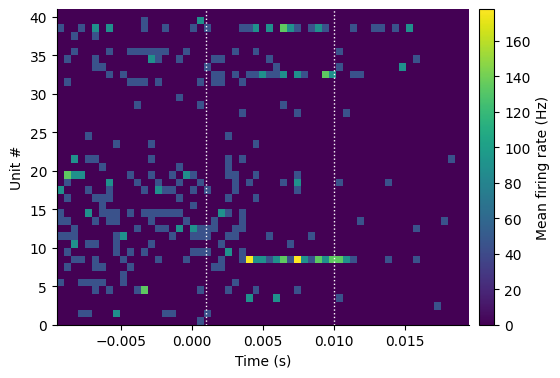

In [ ]:
def plot_optotagging_response(da, bounds=[]):
    n_unit = da.coords['unit_id'].size
    t = da.coords['time_relative_to_stimulus_onset']

    _, ax = plt.subplots(1, 1, figsize=(6.4, n_unit * 0.1))
    im = ax.imshow(da.mean(dim='trial_id').T, extent=[t[0], t[-1], 0, n_unit], aspect='auto')
    for bound in bounds:
        ax.axvline(bound, linestyle=':', color='w', linewidth=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit #')
    plt.colorbar(mappable=im, ax=ax, label='Mean firing rate (Hz)', pad=0.02)
    
plot_optotagging_response(spike_rate, evoked_window)

### Find Cre+ units

In [ ]:
min_rate = 1.  # Hz (minimum rate to avoid 0 firing rate)
evoked_ratio_threshold = 1.5  # threshold for ratio of evoked to baseline

average_dims = ['trial_id', 'time_relative_to_stimulus_onset']
baseline_rate = spike_rate.sel(time_relative_to_stimulus_onset=slice(*baseline_window)).mean(dim=average_dims)
evoked_rate = spike_rate.sel(time_relative_to_stimulus_onset=slice(*evoked_window)).mean(dim=average_dims)

evoked_ratio = (evoked_rate + min_rate) / (baseline_rate + min_rate)
cre_positive = evoked_ratio > evoked_ratio_threshold

Number of Cre+ units: 5


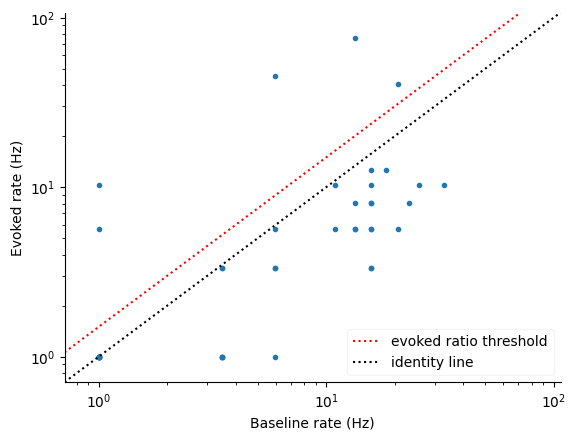

In [ ]:
log_gap = 2 ** 0.5  # gap for log scale plot axis limit
max_rate = max(evoked_rate.max(), baseline_rate.max()) + min_rate
rate_limit = np.array([min_rate / log_gap, max_rate * log_gap])

print(f"Number of Cre+ units: {sum(cre_positive):d}")

_, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
ax.plot(baseline_rate + min_rate, evoked_rate + min_rate, '.')
ax.plot(rate_limit, rate_limit * evoked_ratio_threshold, ':r', label='evoked ratio threshold')
ax.plot(rate_limit, rate_limit, ':k', label='identity line')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(rate_limit)
ax.set_ylim(rate_limit)
ax.set_xlabel('Baseline rate (Hz)')
ax.set_ylabel('Evoked rate (Hz)')
ax.legend(loc='lower right', framealpha=0.2)

plt.show()

### Check waveform duration (spike width)

In [ ]:
spike_width_threshold = 0.5  # ms. Spike width lower than this are interneurons

waveform_duration = sel_units['waveform_duration']

low_spike_width = waveform_duration <= spike_width_threshold
print(f"Number of low spike width units: {sum(low_spike_width):d}")

Number of low spike width units: 11


## Units optotag summary

In [ ]:
optotag_df = pd.DataFrame(dict(
    baseline_rate=baseline_rate,
    evoked_rate=evoked_rate,
    evoked_ratio=evoked_ratio,
    waveform_duration=waveform_duration,
), index=sel_units_id)

Number of positive units: 5


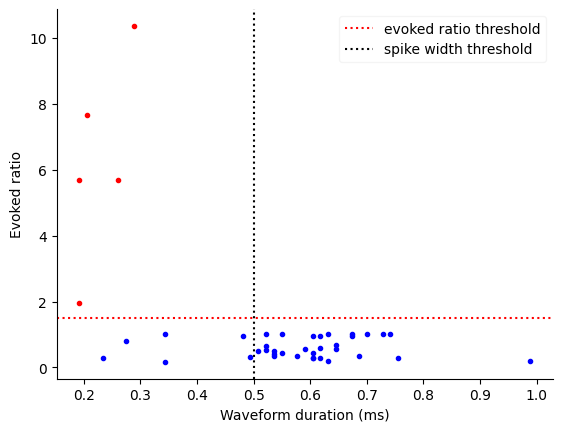

In [ ]:
optotag_df, positive_units = detect_optotag(optotag_df, evoked_ratio_threshold, spike_width_threshold)

print(f"Number of positive units: {positive_units.size:d}")

plot_optotag_units(optotag_df, evoked_ratio_threshold, spike_width_threshold)

plt.show()

In [ ]:
optotag_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_optotag_units.csv')
optotag_df.to_csv(optotag_file)